In [41]:
import pandas as pd
import numpy as np
import yfinance as yf

# Define the stock symbol you want to download data for
stock_symbol = 'AAPL'

# Download the data - the interval used here is minute data
data = yf.download(stock_symbol, interval='1d', start='2010-01-01')

# Flatten the column names if they are MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# The Mean Reversion strategy uses standard deviations, the following chunk optimises for the individual stock 
# The idea is that the signal is only generated when the std dev is hit
def backtest_strategy(data, window=20, std_dev_range=[1,2,3,4,5]):
    results = []
    
    for std_dev in std_dev_range:
        # Create a copy of the data for each iteration
        data_copy = data.copy()
        
        # Calculate the rolling mean and standard deviation
        data_copy['rolling_mean'] = data_copy['Close'].rolling(window=window).mean()
        data_copy['rolling_std'] = data_copy['Close'].rolling(window=window).std()
        
        # Create a signal column that will indicate when to buy or sell
        data_copy['signal'] = 0  # Initialize with 0 instead of None
        
        # Set the signal to 1 when the current price is more than std_dev standard deviations below the rolling mean
        data_copy.loc[data_copy['Close'] < (data_copy['rolling_mean'] - std_dev*data_copy['rolling_std']), 'signal'] = 1
        
        # Set the signal to -1 when the current price is more than std_dev standard deviations above the rolling mean
        data_copy.loc[data_copy['Close'] > (data_copy['rolling_mean'] + std_dev*data_copy['rolling_std']), 'signal'] = -1
        
        # Calculate the profit or loss of the strategy
        data_copy['profit_loss'] = data_copy['signal'].shift(1) * (data_copy['Close'] - data_copy['Close'].shift(1))
        
        # Append the results to the results list
        results.append({'std_dev': std_dev, 'profit_loss': data_copy['profit_loss'].sum()})
    
    # Find the std_dev level that generated the highest profit
    optimal_std_dev = max(results, key=lambda x: x['profit_loss'])['std_dev']
    return optimal_std_dev, results

optimal_std_dev, results = backtest_strategy(data)
print("The optimal std_dev level is: ", optimal_std_dev)
print("The results for different std_dev levels are: ", results)

[*********************100%***********************]  1 of 1 completed

The optimal std_dev level is:  4
The results for different std_dev levels are:  [{'std_dev': 1, 'profit_loss': -57.971989154815674}, {'std_dev': 2, 'profit_loss': -9.365781784057617}, {'std_dev': 3, 'profit_loss': -20.966477394104004}, {'std_dev': 4, 'profit_loss': 0.0}, {'std_dev': 5, 'profit_loss': 0.0}]


In [35]:
# Optimising the volume is done for the same reasons as the std dev 
def backtest_strategy(data, window=20, volume_range=[1,1.5,2,2.5,3]):
    results = []
    for volume_ratio in volume_range:
        # Calculate the rolling mean and standard deviation
        data['rolling_mean'] = data['Close'].rolling(window=window).mean()
        data['rolling_std'] = data['Close'].rolling(window=window).std()
        data['rolling_volume'] = data['Volume'].rolling(window=window).mean()
        data['volume_ratio'] = data['Volume'] / data['rolling_volume']

        # Create a signal column that will indicate when to buy or sell
        data['signal'] = None

        # Set the signal to 1 when the current price is more than 2 standard deviations below the rolling mean
        # and volume is over volume_ratio times the rolling average volume
        data.loc[(data['Close'] < (data['rolling_mean'] - 2*data['rolling_std'])) & (data['volume_ratio']>volume_ratio), 'signal'] = 1

        # Set the signal to -1 when the current price is more than 2 standard deviations above the rolling mean
        # and volume is over volume_ratio times the rolling average volume
        data.loc[(data['Close'] > (data['rolling_mean'] + 2*data['rolling_std'])) & (data['volume_ratio']>volume_ratio), 'signal'] = -1

        # Calculate the profit or loss of the strategy
        data['profit_loss'] = data['signal'].shift(1) * (data['Close'] - data['Close'].shift(1))

        # Append the results to the results list
        results.append({'volume_ratio': volume_ratio, 'profit_loss': data['profit_loss'].sum()})

    # Find the volume_ratio that generated the highest profit
    optimal_volume_ratio = max(results, key=lambda x: x['profit_loss'])['volume_ratio']

    return optimal_volume_ratio, results

data = data
optimal_volume_ratio, results = backtest_strategy(data)

print("The optimal volume ratio is: ", optimal_volume_ratio)
print("The results for different volume ratio levels are: ", results)

The optimal volume ratio is:  3
The results for different volume ratio levels are:  [{'volume_ratio': 1, 'profit_loss': -18.38606071472168}, {'volume_ratio': 1.5, 'profit_loss': -13.80001449584961}, {'volume_ratio': 2, 'profit_loss': -29.037099838256836}, {'volume_ratio': 2.5, 'profit_loss': -14.401521682739258}, {'volume_ratio': 3, 'profit_loss': -2.952362060546875}]


In [36]:
# Strategy

def mean_reversion_strategy(data, window=20):

    # Create a signal column that will indicate when to buy or sell
    data['signal'] = None

    # Set the buy signal to optimised parameters
    data.loc[(data['Close'] < (data['rolling_mean'] - optimal_std_dev*data['rolling_std'])) & (data['volume_ratio']>optimal_volume_ratio), 'signal'] = 1

    # Set the sell signal 
    # and volume is over 1.5 times the rolling average volume
    data.loc[(data['Close'] > (data['rolling_mean'] + optimal_std_dev*data['rolling_std'])) & (data['volume_ratio']>optimal_volume_ratio), 'signal'] = -1

    return data

data = data
mean_reversion_strategy(data)

Price,Close,High,Low,Open,Volume,rolling_mean,rolling_std,rolling_volume,volume_ratio,signal,profit_loss
Date,,,,,,,,,,,
2016-01-04,23.803160,23.807680,23.046249,23.184075,270597600,NaN,NaN,NaN,NaN,None,NaN
2016-01-05,23.206671,23.916134,23.138889,23.893540,223164000,NaN,NaN,NaN,NaN,None,NaN
2016-01-06,22.752531,23.129858,22.564999,22.720899,273829600,NaN,NaN,NaN,NaN,None,NaN
2016-01-07,21.792261,22.623734,21.787743,22.296116,324377600,NaN,NaN,NaN,NaN,None,NaN
2016-01-08,21.907492,22.393271,21.862304,22.266743,283192000,NaN,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-28,200.419998,202.729996,199.899994,200.589996,45339700,204.623365,6.472115,56289900.0,0.805468,None,NaN
2025-05-29,199.949997,203.809998,198.509995,203.580002,51396800,204.009779,6.293074,56245415.0,0.913795,None,NaN
2025-05-30,200.850006,201.960007,196.779999,199.369995,70819900,203.400248,5.953549,56918125.0,1.244242,None,NaN


In [37]:
import vectorbt as vbt
import pandas as pd
import numpy as np

# Assuming you have your data with signals from the mean_reversion_strategy function
# First, let's prepare the data properly for vectorbt

def prepare_vectorbt_long_short_signals(data):
    """Convert signals to vectorbt long/short format"""
    # For long/short strategy:
    # Signal 1 = Go Long (buy when price is below mean - std_dev)
    # Signal -1 = Go Short (sell when price is above mean + std_dev)
    
    long_entries = (data['signal'] == 1).fillna(False)   # Enter long position
    short_entries = (data['signal'] == -1).fillna(False)  # Enter short position
    
    # Exit signals: close position when opposite signal occurs or at neutral zones
    long_exits = (data['signal'] == -1).fillna(False)    # Exit long when short signal
    short_exits = (data['signal'] == 1).fillna(False)    # Exit short when long signal
    
    return long_entries, long_exits, short_entries, short_exits

# Run your strategy and get the signals
data_with_signals = mean_reversion_strategy(data.copy())

# Prepare signals for vectorbt
long_entries, long_exits, short_entries, short_exits = prepare_vectorbt_long_short_signals(data_with_signals)


Portfolio Statistics:
Start                         2016-01-04 00:00:00
End                           2025-06-03 00:00:00
Period                         2368 days 00:00:00
Start Value                               10000.0
End Value                                 10000.0
Total Return [%]                              0.0
Benchmark Return [%]                   753.962275
Max Gross Exposure [%]                        0.0
Total Fees Paid                               0.0
Max Drawdown [%]                              NaN
Max Drawdown Duration                         NaT
Total Trades                                    0
Total Closed Trades                             0
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]        

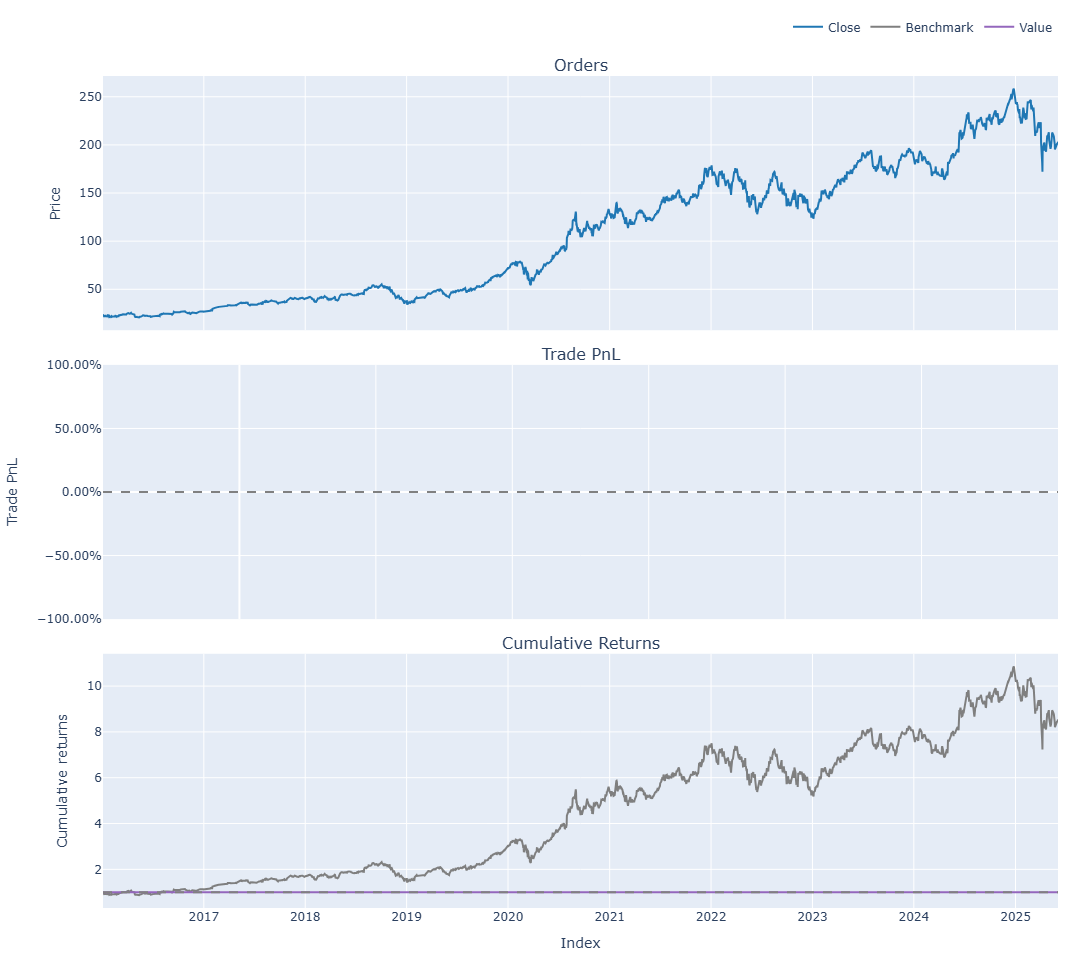

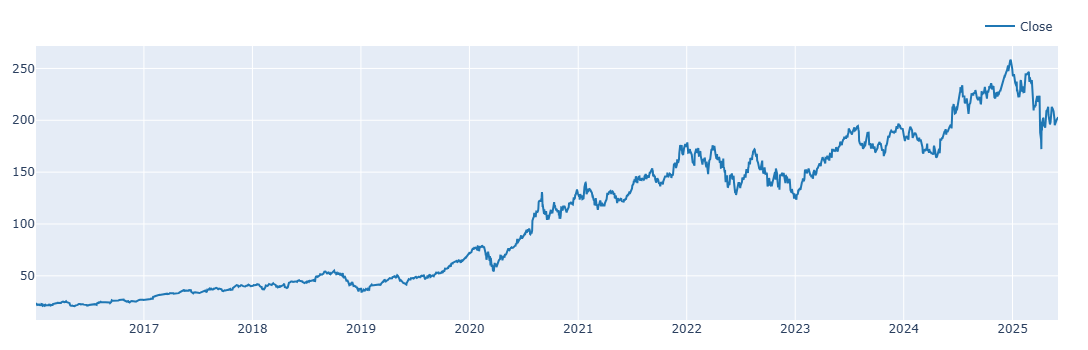

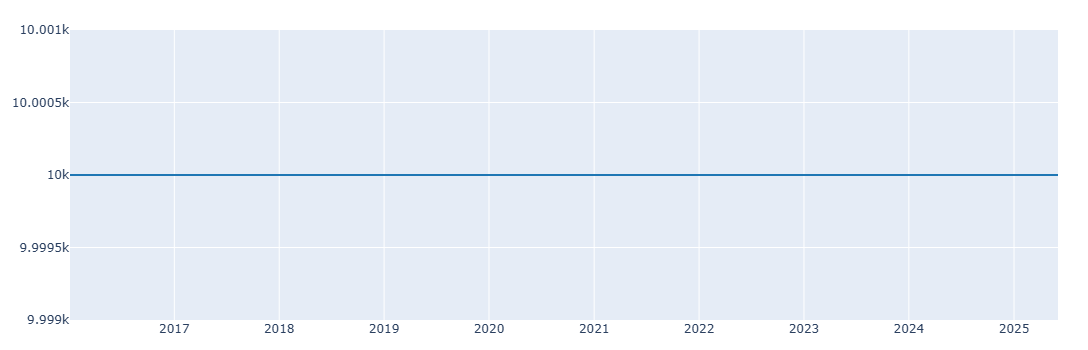

In [38]:
# Create the vectorbt portfolio with long/short capability
pf = vbt.Portfolio.from_signals(
    close=data_with_signals['Close'],
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    init_cash=10000,  
    freq='1d'       # Data frequency
)

# Display portfolio statistics
print("Portfolio Statistics:")
print(pf.stats())

# Plot the portfolio performance
fig = pf.plot()
fig.show()


# Plot individual trades
trades_fig = pf.trades.plot()
trades_fig.show()

# Plot drawdowns
dd_fig = pf.drawdowns.plot()
dd_fig.show()


<Axes: xlabel='Datetime'>

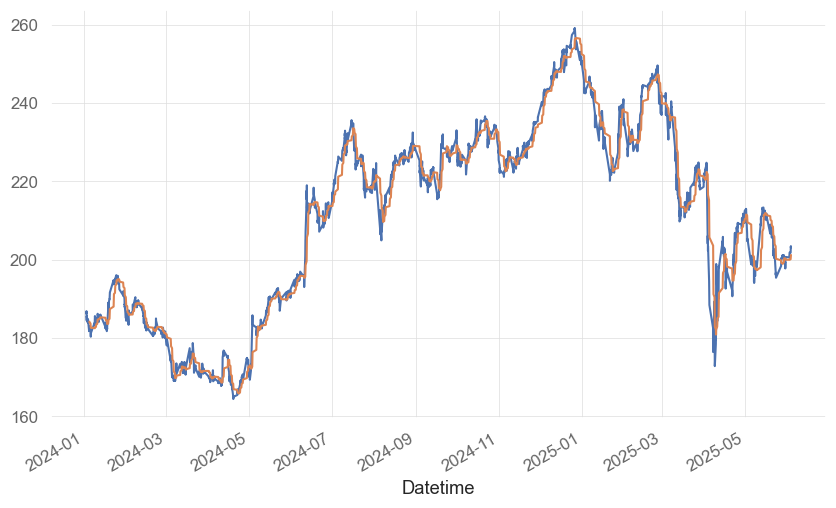

In [29]:
data['Close'].plot()
data['rolling_mean'].plot()

In [25]:
data

Price,Close,High,Low,Open,Volume,rolling_mean,rolling_std,rolling_volume,volume_ratio,signal,profit_loss
Datetime,,,,,,,,,,,
2024-01-02 14:30:00+00:00,186.189896,188.440002,186.009995,187.800995,21173291,NaN,NaN,NaN,NaN,None,NaN
2024-01-02 15:30:00+00:00,186.804993,186.904999,185.184296,186.179993,9010595,NaN,NaN,NaN,NaN,None,NaN
2024-01-02 16:30:00+00:00,186.615005,187.350006,186.570007,186.800003,6143754,NaN,NaN,NaN,NaN,None,NaN
2024-01-02 17:30:00+00:00,185.294998,187.039993,185.259995,186.615005,5381701,NaN,NaN,NaN,NaN,None,NaN
2024-01-02 18:30:00+00:00,184.494995,185.539993,184.229996,185.289993,7228643,NaN,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 15:30:00+00:00,203.054993,203.339996,202.059998,202.520004,4217975,200.382450,1.436375,5187321.30,0.813132,None,NaN
2025-06-03 16:30:00+00:00,203.314606,203.740005,202.720001,203.059998,3820571,200.596181,1.540369,5185185.85,0.736824,None,NaN
2025-06-03 17:30:00+00:00,203.091705,203.770004,202.500000,203.335007,3339508,200.793801,1.596148,5109620.55,0.653573,None,NaN


<Axes: xlabel='Datetime'>

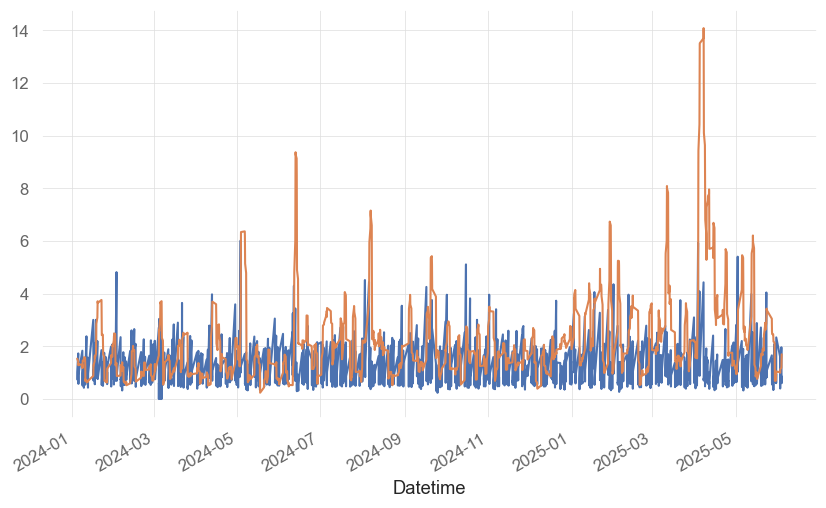

In [31]:
data['volume_ratio'].plot()
data['rolling_std'].plot()